# **Reference**
Part of the script is modified from
https://www.tensorflow.org/tutorials/images/cnn 

In [1]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

## **Dataset**
Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1

https://data.mendeley.com/datasets/4drtyfjtfy/1



In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

import matplotlib.image as img
import skimage.io as io
import sklearn.utils as utils
import skimage.transform as trans

2.10.0


# **1.Initialize**
Assign the class names, number of classes, number of data, labels
*labels are numbers, class names are strings

In [3]:
#init

class_names = ['cloudy','rain','shine','sunrise']
classnum = len(class_names)
datanum = np.array([300,215,253,357]).astype(int)
# divnum = datanum*0.8
# divnum = divnum.astype(int)
labels = []
for i in range(classnum):
  labels.append(i)

In [4]:
# print(divnum,labels, sep='\n')

# **2.Filepath/Filename**
Assign the filepathes </n>

**rootfolder:** filepath of root

**classfolder:** list of folder name of each class

**filename:** 2d list of filename [label][index]


root─┬─class1─┬filename1
</n>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└filename2
</n>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├─class2─
&nbsp;┬filename3


In [5]:
#filepath

rootfolder = 'dataset2'
classfolder = []
filename = []
for i in labels:
  classfolder.append('/'+class_names[i])
  filename.append([])
  for j in range(1,(datanum[i]+1)):
    tmpstr = '/'+class_names[i]+' ('+str(j)+').jpg'
    filename[i].append(tmpstr)

In [6]:
# print(classfolder,filename, sep='\n')

# **3.Load Images**

Load all files as a list and create a corresponding label list

### Reference for loading image:

Fastest approach to read thousands of images into one big numpy array
https://stackoverflow.com/questions/44078327/fastest-approach-to-read-thousands-of-images-into-one-big-numpy-array

Importing Image Data into NumPy Arrays
https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

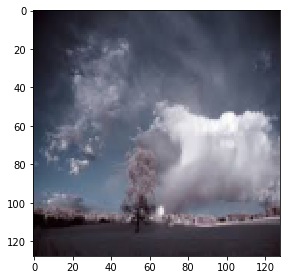

In [7]:
wid = 128
fp = rootfolder+classfolder[0]+filename[0][0]
image = io.imread(fp)
image = trans.resize(image, (wid ,wid), anti_aliasing=True)
io.imshow(image)

In [8]:
#load image

# imagelist = []
# for i in labels:
#   fd = rootfolder+classfolder[i]
#   imagelist.append([])
#   for j in range(datanum[i]):
#     fp=fd+filename[i][j]
#     imagelist[i].append(io.imread(fp))

imagelist = []
width = 128
height = 128
for i in labels:
  fd = rootfolder+classfolder[i]
  for j in range(datanum[i]):
    fp=fd+filename[i][j]
    image = io.imread(fp)
    image_resized = trans.resize(image, (width ,height), anti_aliasing=True)
    imagelist.append(image_resized)

<class 'numpy.ndarray'>
float64
(128, 128, 3)


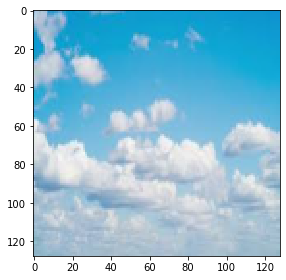

In [9]:
#show image

classindex = 2    #0,1,2,3
imageindex = 120   #300,215,253,357 (max)
index = np.sum(datanum[:classindex])+imageindex
image = imagelist[index]
print(type(image))
print(image.dtype)
print(image.shape)
io.imshow(image)

In [10]:
#list of labels corresponding to the images

labelarray = []
for i in labels:
  tmp = np.full(datanum[i], i)
  labelarray=np.append(labelarray,tmp)
labellist = labelarray.astype(int).tolist()

In [11]:
#remove corrupt data
imgshape = (width,height,3)
popindex=[]
for i in range(len(imagelist)):
  j=imagelist[i]
  if j.shape != imgshape :
    # print(i,j.shape)
    popindex.append(i)
for index in sorted(popindex, reverse=True):
  del imagelist[index]
  del labellist[index]
datanum=len(labellist)

# **4.Shuffle & Split**

Turn the list to ndarray for faster calculation and more convenient operation.

Shuffle the data and labels together then divide them into test group and valid group.

In [12]:
#to array

labelarray = np.array(labellist)
imagearray = np.stack(imagelist,axis=0)

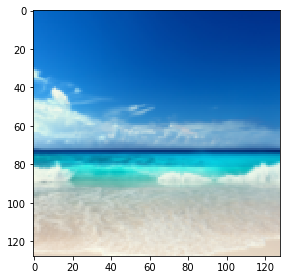

In [13]:
io.imshow(imagearray[666])

In [14]:
#shuffle

shuffler = np.random.permutation(datanum)
shuffledlabels = labelarray[shuffler]
shuffledimages = imagearray[shuffler]
shuffledimages = shuffledimages

In [15]:
print(shuffledimages.shape)

(1120, 128, 128, 3)


In [16]:
#split (train/valid)

alldatanum = int(np.sum(datanum))
div = int(alldatanum*0.8)
train_images = shuffledimages[:div]
train_labels = shuffledlabels[:div]
test_images = shuffledimages[div:]
test_labels = shuffledlabels[div:]

In [17]:
print(train_images.shape)

(896, 128, 128, 3)


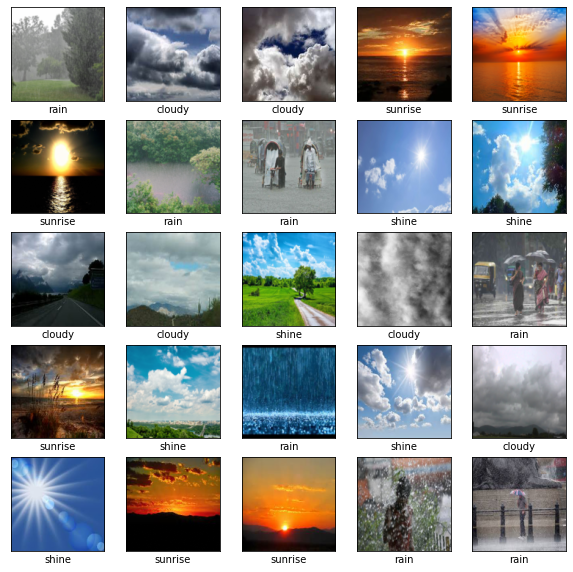

In [18]:
#train data visualization 

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i])
  plt.xlabel(class_names[train_labels[i]])
plt.show()

In [19]:
test_images /= 255.0
train_images /= 255.0

# **5.Create the model**

Add arbritrary layers with arbritrary number of nodes and activate function in each layer.
In the last layer, let the #nodes = #classes.

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

In [21]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(classnum))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 50176)             0

In [22]:
model.compile(optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=20, 
          validation_data=(test_images, test_labels))

Epoch 1/20
28/28 [==============================] - 8s 252ms/step - loss: 1.3795 - accuracy: 0.3136 - val_loss: 1.3764 - val_accuracy: 0.3214
Epoch 2/20
28/28 [==============================] - 7s 236ms/step - loss: 1.3719 - accuracy: 0.3181 - val_loss: 1.3719 - val_accuracy: 0.3214
Epoch 3/20
28/28 [==============================] - 6s 230ms/step - loss: 1.3687 - accuracy: 0.3181 - val_loss: 1.3777 - val_accuracy: 0.3214
Epoch 4/20
28/28 [==============================] - 6s 227ms/step - loss: 1.3680 - accuracy: 0.3181 - val_loss: 1.3666 - val_accuracy: 0.3214
Epoch 5/20
28/28 [==============================] - 6s 228ms/step - loss: 1.3587 - accuracy: 0.3181 - val_loss: 1.3464 - val_accuracy: 0.3214
Epoch 6/20
28/28 [==============================] - 6s 227ms/step - loss: 1.2614 - accuracy: 0.3817 - val_loss: 1.1469 - val_accuracy: 0.4420
Epoch 7/20
28/28 [==============================] - 6s 226ms/step - loss: 1.0296 - accuracy: 0.5413 - val_loss: 0.8916 - val_accuracy: 0.6295
Epoch 

# **6.Validation**

7/7 - 0s - loss: 0.5405 - accuracy: 0.7545 - 376ms/epoch - 54ms/step
0.7544642686843872


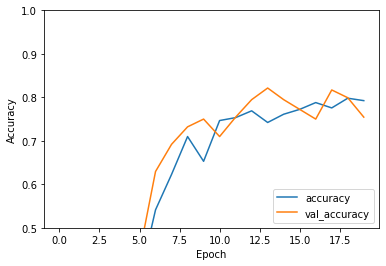

In [23]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)